In [1]:
from IPython.display import display
import graphviz
import json

In [2]:
"""
Compiler logic
"""

from enum import Enum
from typing import Optional

class NodeType(Enum):
    Root = 0
    Char = 1
    Group = 2
    CharacterSet = 3
    Range = 4
    Any = 5
    UNKNOWN = -1

class ExprNode:
    type:   NodeType
    value: Optional[str]
    params: dict[str, any]
    children: list[list['ExprNode']]

    def __init__(self, type: NodeType = None, value: Optional[str] = None):
        self.type = type
        self.value = value
        self.children = []
        self.params = {}



PARAM_ONE_OR_ZERO = '?'
PARAM_ONE_OR_MORE = '+'
PARAM_ANY_OR_MORE = '*'
PARAM_RANGE_START = 'start'
PARAM_RANGE_END   = 'end'

QUANTIFIES = ['?', '+', '*']
SPECIAL_CHARS = ['(', ')', '[', '|', '?', '+' , '*']

class RegexCompiler:
    ast: ExprNode
    expr_str: str
    _position: int

    def __init__(self, expr_str: str):
        self.expr_str = expr_str
        self._position = 0
        self.ast = self._parse(NodeType.Root)
        self.ast.type = NodeType.Root


    def _eat(self, char: Optional[str] = None) -> bool:
        if self._position >= len(self.expr_str):
            return False

        if char is None:
            self._position = self._position + 1
            return True

        for i in range(len(char)):
            if self.expr_str[self._position + i] != char[i]:
                return False
        self._position = self._position + 1
        return True


    def _peak(self, offset: int = 0) -> Optional[str]:
        if self._position + offset >= len(self.expr_str):
            return None
        return self.expr_str[self._position + offset]

    def _done(self):
        return self._position >= len(self.expr_str)

    def _parse(self, curr_type: NodeType = None) -> ExprNode:
        if curr_type == NodeType.Root or curr_type == NodeType.Group:
            return self._parseGroup(is_root=curr_type == NodeType.Root)
        elif curr_type == NodeType.CharacterSet:
            return self._parseSet()
        elif curr_type == NodeType.Char:
            return self._parseChar()
        elif curr_type == NodeType.Any:
            return self._parseAny()
        elif curr_type == NodeType.Range:
            return self._parseRange()
        else:
            raise Exception('Unknown node type')

    def _assignQuantifier(self, node: ExprNode):
        if self._eat(PARAM_ONE_OR_ZERO):
            node.params['quantifier'] = PARAM_ONE_OR_ZERO
        elif self._eat(PARAM_ONE_OR_MORE):
            node.params['quantifier'] = PARAM_ONE_OR_MORE
        elif self._eat(PARAM_ANY_OR_MORE):
            node.params['quantifier'] = PARAM_ANY_OR_MORE

    def _parseGroup(self, is_root: bool = False) -> ExprNode:
        curr_node = ExprNode()
        curr_node.type = NodeType.Group
        curr_node.children.append([])
        curr_or = 0
        while not self._done():
            if self._eat('('): # being of a group
                node = self._parse(NodeType.Group)
                curr_node.children[curr_or].append(node)
                if not self._eat(')'):
                    raise Exception(f'Expected ")" at position {self._position}')
                self._assignQuantifier(node)

            elif self._peak() == ')': # end of group
                if is_root:
                    raise Exception(f'Unexpected "{self._peak()}" at position {self._position}')
                break

            elif self._eat('['): # Characters set
                node = self._parse(NodeType.CharacterSet)
                curr_node.children[curr_or].append(node)
                if not self._eat(']'):
                    raise Exception(f'Expected "]" at position {self._position}')
                self._assignQuantifier(node)

            elif self._peak() == '\\': # match next char
                self._eat()
                node = self._parse(NodeType.Char)
                curr_node.children[curr_or].append(node)
                self._assignQuantifier(node)

            elif self._peak() == '.': # match any char
                node = self._parse(NodeType.Any)
                curr_node.children[curr_or].append(node)
                self._assignQuantifier(node)

            elif self._peak() == '|': # logical or
                self._eat('|')
                curr_node.children.append([])
                curr_or = curr_or + 1

            elif self._peak() not in SPECIAL_CHARS: # normal char
                node = self._parse(NodeType.Char)
                curr_node.children[curr_or].append(node)
                self._assignQuantifier(node)
            else:
                raise Exception(f'Unexpected "{self._peak()}" at position {self._position}')

        return curr_node

    def _parseChar(self) -> ExprNode:
        top = self._peak()
        self._eat(top)
        node = ExprNode()
        node.type = NodeType.Char
        node.value = top
        return node

    def _parseAny(self):
        # same as in _parseChar, I wanted a special function so that I can set
        # node.value = None (or rather, not set it), so that I can be able to
        # identify normal "." char from a "wildcard"
        self._eat('.')
        node = ExprNode()
        node.type = NodeType.Any
        return node

    def _parseSet(self):
        # a set node is just a group node, but we add elements vertically instead of
        # adding them horizontally, also, it can only contain to subtypes: char and range
        curr_node = ExprNode()
        curr_node.type = NodeType.CharacterSet
        next_escape = False
        while not self._done():
            if self._peak() is None:
                raise Exception(f'Unexpected end of expression at position {self._position}')

            if self._peak() == '\\':
                self._eat(None)
                next_escape = True
                continue

            if next_escape:
                next_escape = False
                node = self._parse(NodeType.Range)
                if node is not None:
                    curr_node.children.append([node])
                else:
                    node = self._parse(NodeType.Char)
                    if node is None:
                        raise Exception(f'Unexpected "{self._peak()}" at position {self._position}')
                    curr_node.children.append([node])
            else:
                if self._peak() == ']':
                    break
                node = self._parse(NodeType.Range)
                if node is not None:
                    curr_node.children.append([node])
                else:
                    node = self._parse(NodeType.Char)
                    if node is None:
                        raise Exception(f'Unexpected "{self._peak()}" at position {self._position}')
                    curr_node.children.append([node])
        return curr_node

    def _parseRange(self):
        curr_node = ExprNode()
        curr_node.type = NodeType.Range
        if (
            self._peak(1) == '-'                 # "-" is the letter after next
            and self._peak(2) is not None        # there are at least 3 letters
            and self._peak(2) != ']'             # the second character is not the end of character set
        ):
            start = self._peak(0)
            end = self._peak(2)
            if end == '\\': # special case the second character is escaped
                end = self._peak(3)
                if end is None:
                    return None
                self._eat(None) # extra eat :)

            self._eat(None); self._eat(None); self._eat(None)
            start = ord(start)
            end = ord(end)
            if start > end:
                raise Exception(f'Expected start <= end at position {self._position}')
            curr_node.params[PARAM_RANGE_START] = start
            curr_node.params[PARAM_RANGE_END] = end
        else:
            return None
        return curr_node


In [3]:
"""
NFA Logic
"""
class State:
    def __init__(self, state_id: str, is_final: bool = False):
        self.id = state_id
        self.is_final = is_final
        self.transitions = {}  # char -> Set[State]
        self.epsilon_transitions = set()  # Set[State]

    def add_transition(self, char: str, state):
        if char not in self.transitions:
            self.transitions[char] = set()
        self.transitions[char].add(state)

    def add_epsilon_transition(self, state):
        self.epsilon_transitions.add(state)


class NFA:
    def __init__(self, node: ExprNode = None):
        self.states = []
        self.start_state = None
        self.final_state = None
        self.next_state_id = 0
        self.final_states = set()  # Track all final states

        if node is not None:
            self._build_nfa(node)

    def create_state(self, is_final: bool = False) -> State:
        state = State(self.next_state_id, is_final)
        self.next_state_id += 1
        self.states.append(state)
        if is_final:
            self.final_states.add(state)
            self.final_state = state
        return state

    def set_start_state(self, state: State):
        self.start_state = state

    def add_final_state(self, state: State):
        state.is_final = True
        self.final_states.add(state)
        self.final_state = state

    def _build_nfa(self, node):
        if node.type == NodeType.Char:
            self._build_basic_node_char(node)
        elif node.type == NodeType.Any:
            self._build_basic_node_any(node)
        elif node.type == NodeType.CharacterSet:
            self._build_basic_node_set(node)
        elif node.type == NodeType.Range:
            self._build_basic_node_range(node)
        elif node.type == NodeType.Root or node.type == NodeType.Group:
            self._build_basic_node_group(node)

        # Apply quantifiers if present
        if 'quantifier' in node.params:
            self._apply_quantifier(node.params['quantifier'])

    def _build_basic_node_char(self, node):
        start = self.create_state()
        end = self.create_state(is_final=True)

        # to be able to distinguish between a '.' and a '\.'
        if node.value == '.':
            # "\\\\" instead of "\\" because the graphics library also tries to escape chars
            start.add_transition('\\\\.', end)
        else:
            start.add_transition(node.value, end)

        self.start_state = start
        self.final_state = end

    def _build_basic_node_any(self, node):
        start = self.create_state()
        end = self.create_state(is_final=True)

        # '.' matches any character
        start.add_transition('.', end)

        self.start_state = start
        self.final_state = end

    def _build_basic_node_range(self, node):
        start = self.create_state()
        end = self.create_state(is_final=True)

        # Add transitions for all characters in the range
        range_start = node.params['start']
        range_end = node.params['end']

        # for char_code in range(range_start, range_end + 1):
        #     start.add_transition(chr(char_code), end)

        start.add_transition(f"{chr(range_start)} - {chr(range_end)}", end)

        self.start_state = start
        self.final_state = end

    def _build_basic_node_set(self, node):
        # start = self.create_state()
        # end = self.create_state(is_final=True)
        #
        # # Process all children in the character set
        # # Not sure how to handle ranges here, so just adding a transition for the range itself
        # # also, I'm not sure how to connect elements of character set, so I'll assume they OR-gated instead of
        # # creating NFA for each then connecting them with epsilon transitions
        # for alternative in node.children:
        #     for child in alternative:
        #         if child.type == NodeType.Char:
        #             start.add_transition(child.value, end)
        #         elif child.type == NodeType.Range:
        #             range_start = child.params['start']
        #             range_end = child.params['end']
        #             # for char_code in range(range_start, range_end + 1):
        #             #     start.add_transition(chr(char_code), end)
        #             start.add_transition(f"{chr(range_start)} -> {chr(range_end)}", end)
        #
        # self.start_state = start
        # self.final_state = end
        # # the code above isn't wrong, but it will make the output not identical to the one
        # # in the lecture (will be more optimized heh, which certain "some people" won't like)
        # # so let's just embrace recursion and call it a day :)
        self._build_alternation(node.children)

    def _build_basic_node_group(self, node):
        if not node.children or not node.children[0]:
            # Empty group, create epsilon transition
            start = self.create_state()
            end = self.create_state(is_final=True)
            start.add_epsilon_transition(end)
            self.start_state = start
            self.final_state = end
            return

        # Handle alternation (|)
        if len(node.children) > 1:
            self._build_alternation(node.children)
        else:
            self._build_concatenation(node.children[0])

    def _build_concatenation(self, nodes):
        if not nodes:
            # Empty concatenation, create epsilon transition
            start = self.create_state()
            end = self.create_state(is_final=True)
            start.add_epsilon_transition(end)
            self.start_state = start
            self.final_state = end
            return

        # Build NFA for first node
        sub_nfas = []
        for node in nodes:
            sub_nfa = NFA(node)
            sub_nfas.append(sub_nfa)

        # Connect all sub-NFAs
        if not sub_nfas:
            return

        # Get all states from sub-NFAs
        all_states = []
        for sub_nfa in sub_nfas:
            all_states.extend(sub_nfa.states)

        # Update state IDs to avoid conflicts
        state_map = {}
        for state in all_states:
            new_state = State(self.next_state_id, state.is_final)
            self.next_state_id += 1
            state_map[state] = new_state
            self.states.append(new_state)

        # Copy transitions
        for old_state in all_states:
            new_state = state_map[old_state]

            # Copy char transitions
            for char, targets in old_state.transitions.items():
                for target in targets:
                    if target in state_map:
                        new_state.add_transition(char, state_map[target])

            # Copy epsilon transitions
            for target in old_state.epsilon_transitions:
                if target in state_map:
                    new_state.add_epsilon_transition(state_map[target])

        # Connect the sub-NFAs
        self.start_state = state_map[sub_nfas[0].start_state]

        for i in range(len(sub_nfas) - 1):
            old_final = sub_nfas[i].final_state
            old_next_start = sub_nfas[i + 1].start_state

            state_map[old_final].is_final = False
            state_map[old_final].add_epsilon_transition(state_map[old_next_start])

        self.final_state = state_map[sub_nfas[-1].final_state]
        self.final_states = {state_map[state] for state in state_map if state.is_final}

    def _build_alternation(self, alternatives):
        # Create start and end states
        start = self.create_state()
        end = self.create_state(is_final=True)

        # Build an NFA for each alternative
        for alternative in alternatives:
            if not alternative:
                # Empty alternative, add epsilon transition
                start.add_epsilon_transition(end)
                continue

            # Build a sub-NFA for this alternative
            sub_nfa = NFA()
            sub_nfa._build_concatenation(alternative)

            if not sub_nfa.start_state:
                continue

            # Create a mapping for states to avoid ID conflicts
            state_map = {}
            for state in sub_nfa.states:
                new_state = self.create_state(state.is_final)
                state_map[state] = new_state

            # Copy transitions
            for old_state in sub_nfa.states:
                new_state = state_map[old_state]

                # Copy char transitions
                for char, targets in old_state.transitions.items():
                    for target in targets:
                        if target in state_map:
                            new_state.add_transition(char, state_map[target])

                # Copy epsilon transitions
                for target in old_state.epsilon_transitions:
                    if target in state_map:
                        new_state.add_epsilon_transition(state_map[target])

            # Connect start to sub-NFA's start
            start.add_epsilon_transition(state_map[sub_nfa.start_state])

            # Connect sub-NFA's final states to end
            for old_state in sub_nfa.states:
                if old_state.is_final:
                    state_map[old_state].is_final = False
                    state_map[old_state].add_epsilon_transition(end)

        self.start_state = start
        self.final_state = end

    def _apply_quantifier(self, quantifier):
        if not self.start_state or not self.final_state:
            return

        # Save original start and final states
        original_start = self.start_state
        original_final = self.final_state

        # Create new start and final states
        new_start = self.create_state()
        new_final = self.create_state(is_final=True)

        # Remove final state flag from original final state
        original_final.is_final = False

        if quantifier == '?':  # Zero or one occurrence
            # Connect new_start to original_start and new_final
            new_start.add_epsilon_transition(original_start)
            new_start.add_epsilon_transition(new_final)

            # Connect original_final to new_final
            original_final.add_epsilon_transition(new_final)

        elif quantifier == '*':  # Zero or more occurrences
            # Connect new_start to original_start and new_final
            new_start.add_epsilon_transition(original_start)
            new_start.add_epsilon_transition(new_final)

            # Connect original_final to original_start and new_final
            original_final.add_epsilon_transition(new_start)
            original_final.add_epsilon_transition(new_final)

        elif quantifier == '+':  # One or more occurrences
            # Connect new_start to original_start
            new_start.add_epsilon_transition(original_start)

            # Connect original_final to original_start and new_final
            original_final.add_epsilon_transition(new_start)
            original_final.add_epsilon_transition(new_final)

        self.start_state = new_start
        self.final_state = new_final
        self.final_states = {state for state in self.states if state.is_final}

    def to_dot(self, regex_str=None):
        """Convert the NFA to a Graphviz DOT representation for visualization"""
        dot = graphviz.Digraph(comment='NFA')

        # Set graph to display horizontally
        dot.attr(rankdir='LR')
        # dot.attr(dpi="300")
        # dot.attr(ratio="1")
        # dot.attr(size="10,10", dpi="300")

        # Add start indicator
        if self.start_state:
            dot.node('start', '', shape='point')
            dot.edge('start', f"S{self.start_state.id}")

        # Add all states
        for state in self.states:
            node_id = f"S{state.id}"
            if state.is_final:
                dot.node(node_id, f"S{state.id}", shape='doublecircle', style='filled', fillcolor='lightgray')
            elif state == self.start_state:
                dot.node(node_id, f"S{state.id}", shape='circle', style='filled', fillcolor='lightblue')
            else:
                dot.node(node_id, f"S{state.id}", shape='circle')


        # Add all transitions
        for state in self.states:
            src_id = f"S{state.id}"

            # Add normal transitions
            for char, targets in state.transitions.items():
                for target in targets:
                    dot.edge(src_id,
                             f"S{target.id}",
                             label=char,
                             color='green',
                    )

            # Add epsilon transitions
            for target in state.epsilon_transitions:
                dot.edge(src_id, f"S{target.id}", label='ε', color='saddlebrown', fontcolor='saddlebrown')

        # Add the regex string at the bottom if provided
        if regex_str:
            escp = ""
            for char in regex_str:
                if char == '\\':
                    escp = escp + char * 2
                else:
                    escp = escp + char
            dot.attr(label=f"Regular Expression: {escp}")
            dot.attr(labelloc='b')  # Place label at bottom

        return dot

    def render_to_file(self, filename='nfa', format='png', regex_str=None):
        """Render the NFA to a file"""
        dot = self.to_dot(regex_str)
        dot.render(filename, format=format, cleanup=True)
        return dot

    def to_json(self):
        """Convert the NFA to a JSON representation"""
        result = {}

        # Add starting state
        if self.start_state:
            result["startingState"] = f"S{self.start_state.id}"

        # Add all states
        for state in self.states:
            state_id = f"S{state.id}"
            state_data = {
                "isTerminatingState": state.is_final
            }

            # Add regular transitions
            for char, targets in state.transitions.items():
                if len(targets) == 1:
                    target = next(iter(targets))
                    state_data[char] = f"S{target.id}"
                else:
                    state_data[char] = []
                    for target in targets:
                        state_data[char].append(f"S{target.id}")

                        # Add epsilon transitions
            for target in state.epsilon_transitions:
                # Use 'ε' as the key for epsilon transitions
                if 'ε' not in state_data:
                    state_data['ε'] = []
                state_data['ε'].append(f"S{target.id}")

            result[state_id] = state_data

        return result

    def save_json(self, filename='nfa.json'):
        """Save the NFA as a JSON file"""
        import json
        with open(filename, 'w') as f:
            json.dump(self.to_json(), f, indent=2, ensure_ascii=False)
        return filename

In [4]:
"""
DFA Logic
"""

class DFA_State:
    def __init__(self, nfa_states : set[State], is_final: bool = False):
        self.states : set[State] = nfa_states
        self.id : str = self.set_to_string()
        self.is_final : bool = is_final

    def set_to_string(self): # for printing and hashing
        """Build the name of this DFA state by concatenating names of included NFA states"""
        ids = {s.id for s in self.states}
        return " ".join(map(str, ids))

    def __hash__(self):
        return hash(self.id)  # Ensures identical DFA states are treated as the same key

    def __eq__(self, other):
        return isinstance(other, DFA_State) and self.id == other.id

class DFA:

    def __init__(self, json_file_path : str, minimized : bool):
        self.nfa : NFA = NFA()
        self.states : set[DFA_State] = set()
        self.start_state : DFA_State = None
        self.final_states : set[DFA_State] = set()
        self.actions : list[str] = []
        self.transitions : list[tuple[DFA_State, DFA_State, str]] = []   # set[(source_state, target_state, action)]
        self.__build(json_file_path, minimized)

    def __epsilon_closure(self, state : State) -> set[State]:
        """Find all states reachable from the given state via epsilon transitions"""
        all_states : set[State] = {state}
        stack : list[State] = [state]

        while stack:
            state = stack.pop()
            state = self.nfa.states[int(state.id[1:])]
            for action, targets in state.transitions.items():
                for target in targets:
                    if target not in all_states and action == "ε":
                        all_states.add(target)
                        stack.append(target)
        return all_states

    def __get_reachable_states(self, dfa_state : DFA_State, action : str) -> set[State]:
        """Find all reachable states from the given state given an action"""
        reachable_states : set[State] = set()

        # for each NFA state in current DFA state
        for nfa_state in dfa_state.states:
            curr_reachable_states : set[State] = None
            if action in nfa_state.transitions:
                curr_reachable_states = nfa_state.transitions[action]

                # for each state that can be reached from curr reaches states
                next_reachable_states : set[State] = set()
                for next_state in curr_reachable_states:
                    next_reachable_states |= self.__epsilon_closure(next_state) # append sets of states
                curr_reachable_states |= next_reachable_states # append sets of states

                reachable_states |= curr_reachable_states # append sets of states

        return reachable_states

    def __load_NFA_json(self, file_path):
        """Construct NFA states and transitions"""
        ### i assume here that states in json file are increasingly sorted ###
        with open(file_path, 'r') as file:
            data = json.load(file)

        start = data["startingState"]

        # Creating NFA states
        for state_name, state_data in data.items():
            if state_name == "startingState":
                continue
            is_final = state_data["isTerminatingState"]
            current_state = State(state_name, is_final)
            self.nfa.states.append(current_state)
            if is_final:
                self.nfa.final_state = current_state # Assign final state of NFA
            elif state_name == start:
                self.nfa.start_state = current_state # Assign start state of NFA

        # Adding NFA transitions
        for state_name, state_data in data.items():
            if state_name == "startingState":
                continue
            current_state : State = self.nfa.states[int(state_name[1:])]
            for action, targets in state_data.items():
                if action == "isTerminatingState":
                    continue
                if isinstance(targets, list):
                    for target in targets:
                        current_state.add_transition(action, self.nfa.states[int(target[1:])])
                else:
                    current_state.add_transition(action, self.nfa.states[int(targets[1:])])
                # Add actions
                if action != "ε":
                    self.actions.append(action)

        # # debugging
        # for state in self.nfa.states:
        #     print("Curr State: ", state.id)
        #     for a, tgt_states in state.transitions.items():
        #         print("Action: ", a)
        #         for t in tgt_states:
        #             print("Target State: ", t.id)

    def __construct_DFA(self, json_file_path):

        self.__load_NFA_json(json_file_path)

        # Get start state of DFA
        self.start_state = DFA_State(self.__epsilon_closure(self.nfa.start_state))
        self.states.add(self.start_state)

        # Check if the start state is also a terminating state
        if self.nfa.final_state in self.start_state.states:
            self.final_states.add(self.start_state)

        stack : list[DFA_State] = [self.start_state]
        # while there are DFA states
        while stack:
            curr_dfa_state = stack.pop()
            # for every action possible check if we can create a new DFA state
            for action in self.actions:
                new_dfa_state = DFA_State(self.__get_reachable_states(curr_dfa_state, action))

                if len(new_dfa_state.states) == 0: continue # empty state

                # create the new state if it is really "new" :v
                if not any(new_dfa_state.id == s.id for s in self.states):
                    self.states.add(new_dfa_state)
                    stack.append(new_dfa_state)
                    # check if it is a terminating state
                    if self.nfa.final_state in new_dfa_state.states:
                        self.final_states.add(new_dfa_state)

                # add transition between current state and new state (new state can be the current state)
                if (curr_dfa_state, new_dfa_state, action) not in self.transitions:
                    self.transitions.append((curr_dfa_state, new_dfa_state, action))

    def __create_transition_table(self) -> dict[DFA_State, dict[str, DFA_State]]:
        """Creates a transition table for every DFA state with every action possible"""
        transition_table : dict[DFA_State, dict[str, DFA_State]] = {}
        for (src_state, target_state, action) in self.transitions:
            if src_state not in transition_table:
                transition_table[src_state] = {}
            transition_table[src_state][action] = target_state

        # Add states that doesn't have actions
        # as we handle actions that doesn't transition the state as actions that transit the state to a 'None' state
        for state in self.states:
            if state not in transition_table:
                transition_table[state] = {}

        return transition_table

    def __split_states(self, transition_table : dict[DFA_State, dict[str, DFA_State]]):
        state_to_group : dict[DFA_State, int] = {} # map every state to its group
        group_to_state : dict[int, set[DFA_State]] = {0 : set(), 1 : set()} # map every group to its states

        # Create first two groups (accepting, non accepting)
        for state in self.states:
            if state in self.final_states:  # accepting group
                state_to_group[state] = 1
                group_to_state[1].add(state)
            else:                           # non-accepting group
                state_to_group[state] = 0
                group_to_state[0].add(state)

        num_of_groups = 2 # current number of groups
        non_accepting_group = group_to_state[0]
        accepting_group = group_to_state[1]
        # Stack to process every existing group
        stack : list[set[DFA_State]] = [non_accepting_group, accepting_group]
        # Split groups until no change
        while True:
            size : int = len(stack)
            currLen : int = size
            # Process current list of groups
            while size:
                size -= 1
                # Process current group
                curr_states = stack.pop(0)
                # if length of curr states equal 1, then we can't split,
                # or length equals 0 (there is no non-accepting states),
                # add it as it is and skip it
                if len(curr_states) <= 1:
                    stack.append(curr_states)
                    continue
                # Get current representative of this group (first one or anyone, doesn't matter)
                curr_representative = list(curr_states)[0]
                new_states : set[DFA_State] = set() # set of states that should be splitted to another group
                # For each action possible
                for action in self.actions:
                    # Get what group representative goes to and check if all other states are the same
                    curr_target = transition_table[curr_representative].get(action, None)
                    target_group = None
                    if curr_target:
                        target_group = state_to_group[curr_target]
                    # For every state in the current group check if they should be splitted
                    for state in curr_states:
                        target_state = transition_table[state].get(action, None)
                        # if current action transits both the representative and the current state to 'None' state, then no split required
                        if (curr_target == None or target_state == None) and target_state == curr_target:
                            continue
                        # states goes to different groups, we need to split them
                        if target_state == None or state_to_group[target_state] != target_group:
                            # Add this state to a new group
                            new_states.add(state)
                # Remove states that should be splitted from current group
                curr_states = set([s for s in curr_states if s not in new_states])
                # If we made a split create the new group and add both the modified curr group and the new group to the stack to process them again
                if len(new_states) > 0:
                    # Create new group for splitted states
                    # For every splitted state
                    for s in new_states:
                        # Remove it from its curr group
                        group = state_to_group[s]
                        group_to_state[group].remove(s)
                        # Update its group id
                        state_to_group[s] = num_of_groups
                        # Add it to its new group
                        if num_of_groups not in group_to_state:
                            group_to_state[num_of_groups] = set()
                        group_to_state[num_of_groups].add(s)
                    # Add both the modified curr group and the new group
                    stack.append(curr_states)
                    stack.append(new_states)
                    # Increment number of groups as we created one more group
                    num_of_groups += 1
                else: # If we didn't make a split add curr group again
                    stack.append(curr_states)
            # If no split done terminate the algorithm
            if currLen == len(stack): break
        return state_to_group, group_to_state

    def __group_to_state(self, group : set[DFA_State], group_id : int = None):
        """Convert a group (set of DFA states) to a single DFA state
            by just concatenating the ids of all NFA states in every DFA state in the group
        """
        all_nfa_states = set()
        is_final = False
        is_start = False
        for dfa_state in group:
            if dfa_state == self.start_state:
                is_start = True

            if dfa_state in self.final_states:
                is_final = True

            all_nfa_states |= dfa_state.states

        new_dfa_state = None
        if group_id != None:
            s = State("G" + str(group_id))
            st = set()
            st.add(s)
            new_dfa_state = DFA_State(st, is_final)
        else:
            new_dfa_state = DFA_State(all_nfa_states, is_final)

        if is_start:
            self.start_state = new_dfa_state

        return new_dfa_state

    def __update_transitions(self, state_to_group : dict[DFA_State, int], group_to_state : dict[int, set[DFA_State]]):
        # Clear the DFA to create the new 'minimizaed' states
        self.states = set()
        # List of new transitions between new 'minimized' states
        new_transitions : list[tuple[DFA_State, DFA_State, str]] = []
        # Process old transitions and map every old DFA state to its group then create a new DFA state for the whole group
        # For every old transition
        for (src_state, target_state, action) in self.transitions:
            # Get source state group and convert it to a DFA state
            src_group = state_to_group[src_state]
            src = group_to_state[src_group]
            src = self.__group_to_state(src, src_group)

            # Get target state group and convert it to a DFA state
            target_group = state_to_group[target_state]
            target = group_to_state[target_group]
            target = self.__group_to_state(target, target_group)

            # Add new states to the DFA
            self.states.add(src)
            self.states.add(target)

            # Add final states
            if src.is_final:
                self.final_states.add(src)

            # Add start state
            if target.is_final:
                self.final_states.add(target)
            # Add the new transition (source group, target group, action)
            if (src, target, action) not in new_transitions:
                new_transitions.append((src, target, action))

        # Update transitions
        self.transitions = new_transitions

    def to_json(self):
        """Convert the DFA to a JSON representation"""
        result = {}

        # Add starting state
        if self.start_state:
            result["startingState"] = self.start_state.id

        # Process transitions
        for (src_state, target_state, action) in self.transitions:
            if src_state.id not in result:
                result[src_state.id] = {}
                result[src_state.id]["isTerminatingState"] = src_state.is_final
            result[src_state.id][action] = target_state.id

        return result

    def __minimize_DFA(self):
        transition_table = self.__create_transition_table()
        state_to_group, group_to_state = self.__split_states(transition_table)
        self.__update_transitions(state_to_group, group_to_state)

    def to_dot(self, regex_str = None):
        """Convert the DFA to a Graphviz DOT representation for visualization"""
        dot = graphviz.Digraph(comment='DFA')

        # Set graph to display horizontally
        dot.attr(rankdir='LR')

        # Add all states
        for state in self.states:
            if state in self.final_states:
                dot.node(state.id, shape='doublecircle', style='filled', fillcolor='lightgray')
            elif state == self.start_state:
                dot.node(state.id, shape='circle', style='filled', fillcolor='lightblue')
            else:
                dot.node(state.id, shape='circle')

        # Add start indicator
        if self.start_state:
            dot.node('start', '', shape='point')
            dot.edge('start', self.start_state.id)

        # Add all transitions
        for src_state, target_state, action in self.transitions:
            dot.edge(src_state.id,
                        target_state.id,
                        label=action,
                        color='green',
            )

        # Add the regex string at the bottom if provided
        if regex_str:
            escp = ""
            for char in regex_str:
                if char == '\\':
                    escp = escp + char * 2
                else:
                    escp = escp + char
            dot.attr(label=f"Regular Expression: {escp}")
            dot.attr(labelloc='b')  # Place label at bottom

        return dot

    def __build(self, json_file_path : str, minimized : bool):
        self.__construct_DFA(json_file_path)
        if minimized:
            self.__minimize_DFA()

    def render_to_file(self, filename='dfa', format='png', regex_str=None):
            """Render the DFA to a file"""
            dot = self.to_dot(regex_str)
            dot.render(filename, format=format, cleanup=True)
            return dot

    def save_json(self, filename='nfa.json'):
        """Save the NFA as a JSON file"""
        import json
        with open(filename, 'w') as f:
            json.dump(self.to_json(), f, indent=2, ensure_ascii=False)
        return filename


In [5]:
"""
Handy functions
"""

def _epsilon_closure(states):
    """Find all states reachable from the given states via epsilon transitions"""
    all_states = set(states)
    stack = list(states)

    it = 0
    while stack:
        it = it + 1
        state = stack.pop()
        for target in state.epsilon_transitions:
            if target not in all_states:
                all_states.add(target)
                stack.append(target)

        if it > 10000:
            break # a limit to how much we can explore.

    return all_states

def match_fa(start_state, input_string):
    """Match input string against the FA"""

    # Find all possible states reachable from start state via epsilon transitions
    current_states = _epsilon_closure({start_state})

    # Process each character
    for char in input_string:
        next_states = set()

        # For each current state, find all next states via char transitions
        for state in current_states:
            for transition_char , targets in state.transitions.items():
                # Handle '.' as wildcard and ranges, this is probably the ugliest way to do it, but it works :)
                split = str(transition_char).split(" - ")
                if (
                    transition_char == '.' or
                    transition_char == char or
                    (char == '.' and transition_char == '\\\\.') or
                    (len(split) == 2 and ord(split[0]) <= ord(char) <= ord(split[1]))
                ):
                    next_states.update(targets)

        # Find epsilon closures for all next states
        current_states = _epsilon_closure(next_states)

        # If we have no states left, matching fails
        if not current_states:
            return False

    # Check if any current state is a final state
    return any(state.is_final for state in current_states)

def regex_to_nfa(regex_str: str):
    """Convert a regular expression string to an NFA"""
    regex = RegexCompiler(regex_str)
    return NFA(regex.ast)


def match(regex_str: str, test_str: str):
    """Test if a string matches a regular expression"""
    _nfa = regex_to_nfa(regex_str)
    return match_fa(_nfa.start_state, test_str)

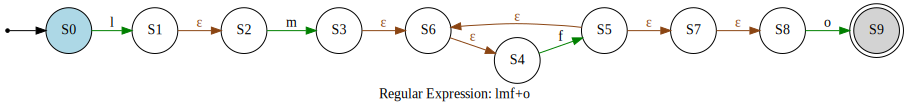

Match string:  lmfo
Match Result:  True


In [6]:
"""
just a little test :)
"""

expr = "lmf+o"
text = "lmfo"
nfa = regex_to_nfa(expr)
dot = nfa.to_dot(expr)
display(dot)

print("Match string: ", text)
print("Match Result: ", match_fa(nfa.start_state, text))

NFA Graph


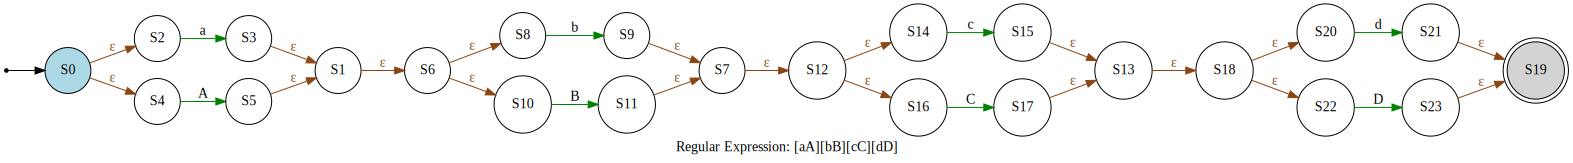

DFA Graph


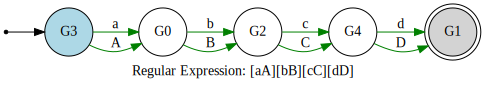

Match "AbDo": False


In [7]:
"""
TESTING ZONE
set minimize to false to see the DFA before doing the minimization
"""

minimize = True

def process_test_case(expr: str, text: str):
    nfa = regex_to_nfa(expr)
    nfa_dot = nfa.to_dot(expr)
    nfa.save_json("nfa.json")
    print("NFA Graph")
    display(nfa_dot)

    dfa = DFA("nfa.json", minimized=minimize)
    dfa_dot = dfa.to_dot(expr)
    dfa.save_json("dfa.json")
    print("DFA Graph")
    display(dfa_dot)

    if text is not None and len(text) > 0:
        print(f"Match \"{text}\": {match_fa(nfa.start_state, text)}")

TEST_EXPR = input("Enter expression to test: ")
TEST_TEXT = input("Enter text to match: ")

process_test_case(TEST_EXPR, TEST_TEXT)